# AIML Assignment 2: Unsupervised Learning
## Background: The Decline of Retail Malls

In August 2021, it was reported that retail sales in Singapore had risen by 25.8% on a year on year basis from 2020. [Source: CNA](https://www.channelnewsasia.com/singapore/retail-sales-index-food-beverage-june-2021-2094341)

However, this was due to the shut down of physical stores as a result of the COVID-19 pandemic. Hence, this percentage rise was calculated on a low base, and hides a trend that has been occuring even before COVID-19, which is the decline in physical retail shopping. 

According to the Singapore Department of Statistics (SingStat), The average retail sales per square meter has fallen by around $400/m2 from 2009 to 2019, mostly due to a decline in general merchandise sales, where retail sales per square meter has fallen by more than $2000/m2. [Source: Department of Statistics, Singapore](https://www.singstat.gov.sg/modules/infographics/retail)

In contrast to the decline in physical retail, SingStat reports that 2021 saw an increase in online retail sales.

Thus, mall operators around Singapore face a growing threat. Their business model is based mostly around leasing space to retail shops, and earning money off the rent. If physical retail becomes less popular, there will be a decline in shops, and thus rental fees, reducing their revenue stream.

## Problem Statement

One way for malls to maintain their revenue streams is to better understand their customers, so as to determine a core customer case, for which a marketing strategy can be devised to retain their loyalty. 

Hence, our objective is to applying clustering techniques to segment our customers, and identify a customer segment to target.



## Library Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Statistical Analysis
from scipy import stats

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import Pipeline
# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering ,DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram


# Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer
sns.set()

rng = np.random.RandomState(42)

## Data Ingestion

In [2]:
df = pd.read_csv("Mall_Customers.csv", index_col=0)
df.head()

Genre  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1             Male   19                  15                      39
2             Male   21                  15                      81
3           Female   20                  16                       6
4           Female   23                  16                      77
5           Female   31                  17                      40

## Exploratory Data Analysis

Before embarking on our customer segmentation task, we will take some time to explore the data, to gain a better understanding of our customer base.

### Dataset Features


| Features | Data Type | Description |
|---|---|---|
|Gender | Categorical | Either Male or Female |
| Age | Numerical (Discrete) | How old the customer is. |
| Annual Income (k$) | Numerical (Continuous) | Annual income in thousands (assume USD) |
| Spending Score (1-100) | Categorical (Ordinal) | Spending behaviour, a high spending score might indicate a customer who spends more money in the mall |


### Questions
- How many observations are there in the data?
- Are there any errors or missing values in the data?
- What does the distribution of the features look like?
- Is there any relationship between the variables in the data?
- How important is gender in affecting the distribution of the data?

In [3]:
df_eda = df.copy(deep=True)

### How many observations are there in the data?

In [4]:
rows, cols = df_eda.shape
print("There are {} rows and {} columns in the data.".format(rows, cols))

There are 200 rows and 4 columns in the data.


### Are there any errors or missing values in the data?

In [5]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Genre                   200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


On first glance,
- it appears there are no missing values in the data
- the "Gender" column is mispelled as "Genre"
- the data types for each attribute are correct

We will fix the misnamed column by renaming it to the proper name.

In [6]:
df.rename(columns={"Genre" : "Gender"}, inplace=True)
df_eda.rename(columns={"Genre" : "Gender"}, inplace=True)

In [7]:
df_eda.describe()

Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000

From looking at the descriptive statistics, nothing stands out as being particularly anomalous.

### Data Distributions

In [8]:
df_eda.describe()

Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000

- The mean age of 38.85 (approximately 39) is higher than the median age of 36, suggesting the distribution of age is positively skewed
- The typical customer of the mall is middle aged, as approximately 50% of all customers are between 28 and 49 years old
- The mean annual income is similar to the median annual income, suggesting the distribution is not significantly skewed.
- The mean spending is similar to the median spending score, suggesting that the distribution is not significantly skewed.

C:\Users\tienc\AppData\Local\Temp/ipykernel_7044/2946662355.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


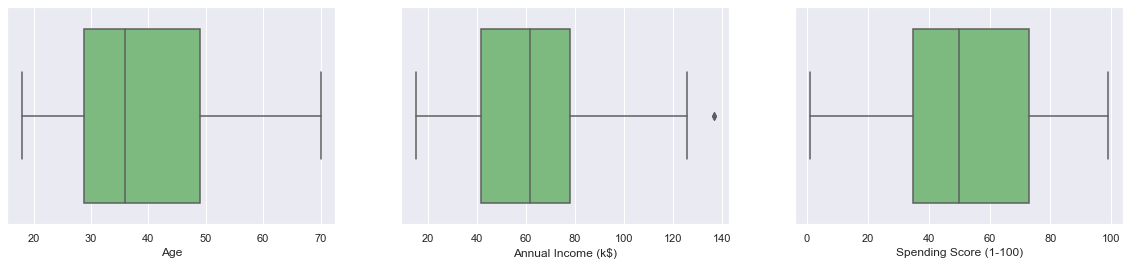

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax, col in zip(axes, df_eda.drop('Gender', axis=1).columns):
    sns.boxplot(data=df_eda, x=col, ax = ax, palette="Greens")
fig.show()

#### Age
- As initially discovered from the descriptive statistics, we see that the age distribution is positively skewed, and that most customers are middle aged.

#### Annual Income
- We see that the majority of customers earn between $3000 to $7000 per month. 
- This is consistent with the average incomes of Singaporeans, which stands at around $5.7K per month ($68.4k annually)
- This suggest that most of our customers have a middle class background, as such wages would be typical of white collar jobs.
- We could potentially increase the spending power of our average customers by offering a buy now, pay later scheme, where they pay in interest free installments.
- There are a minority of customers that earn in excess of $90k per year, meaning that they have significant spending power.
- We observe that we have a single outlier, who earns close to $140,000 annually (or close to $11k per month)

#### Spending Score

- Most shoppers have spending scores between 35 and 70
- There are no customers with outlier spending scores.
- The distribution of spending scores is slightly positively skewed.

In [10]:
(df_eda['Annual Income (k$)'] / df_eda['Spending Score (1-100)']).describe()

count    200.000000
mean       2.824117
std        8.025789
min        0.185185
25%        0.884773
50%        1.126136
75%        1.581255
max       78.000000
dtype: float64

<AxesSubplot:>

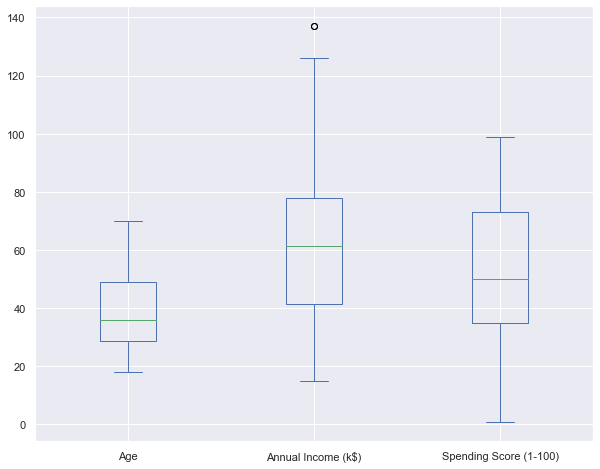

In [11]:
df_eda.plot(kind='box', figsize=(10, 8))

- From analysing the box plots, we note that Annual Income and Spending score have similar interquartile ranges
- Age has a slightly smaller interquartile range

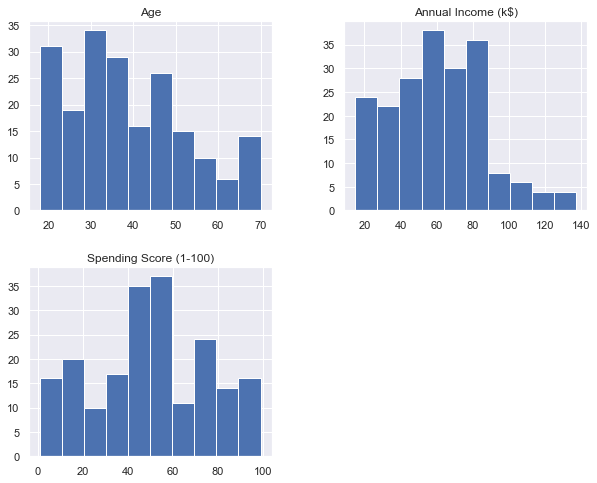

In [12]:
df_eda.hist(figsize=(10, 8))
plt.show()

<AxesSubplot:xlabel='Gender', ylabel='count'>

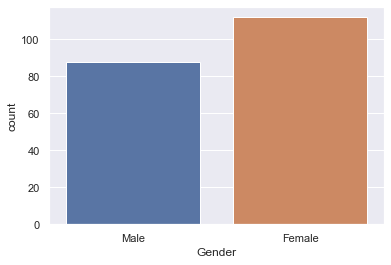

In [13]:
sns.countplot(data=df_eda, x='Gender')

We observe that most of our customers are females (56% of customers). According to the [Ministry of Social and Family Development](https://www.msf.gov.sg/research-and-data/Research-and-Statistics/Pages/Singapore-Demographic-Sex-Ratio-Males-to-Females.aspx), in 2019 there were 957 males for every 1000 females (51% Females). Hence, the demographics of our mall appear to reflect societal demographics. 

Given the male-female ratio of the mall, it may be advantageous to ensure that there are anemenities and shops catered towards women in particular. 

### Is there any relationship between the variables in the data?

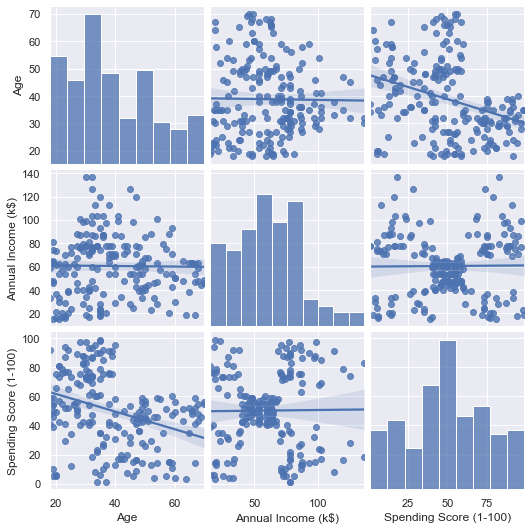

In [14]:
sns.pairplot(df_eda, kind='reg')

- Between Age and Annual Income, there does not appear to be any significant relationship
- It appears that younger people tend to have a higher spending score. This could be because older people have less need to purchase items
- Annual Income and Spending Score appears to form 5 natural clusters

<AxesSubplot:>

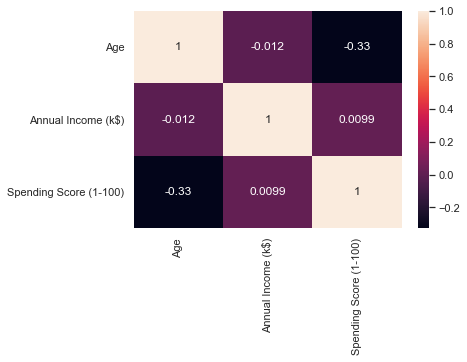

In [15]:
sns.heatmap(df_eda.corr(), annot=True)

- The correlation heatmap appears to support our observations that there is a negative weak linear relationship between age and spending score

### How important is gender in affecting the distribution of the data?

Our dataset contains the Gender feature. In theory, customers of different genders may have different spending habits. For example, we might expect female customers to spend more money on cosmetics products, which are mainly targeted at females. This suggests that the feature may be useful.

However, the gender feature poses a few problems for our customer segmentation:
- Gender is a categorical variable. Even if encoded into a binary 1 and 0, certain clustering techniques (e.g. KMeans with Eucluidian distances) may not make sense, as the euclidian distance between Males and Females makes not sense at all. The resulting cluster center coordinate for Gender would also not make sense as well. This could be solved by using other clustering methods (e.g. K-Prototypes).
- We already have three other features. Hence, visualising the clustering would require us to visualise 4 dimensions (gender, age, spending, income, and the cluster labels). This means that we would have to drop one of other features if we want to use the Gender feature.

Hence, we want to determine if there is a significant difference between the demographics and habits of both genders. This may help us decide on a future course of action for what to do with the feature. 

C:\Users\tienc\AppData\Local\Temp/ipykernel_7044/1139392611.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


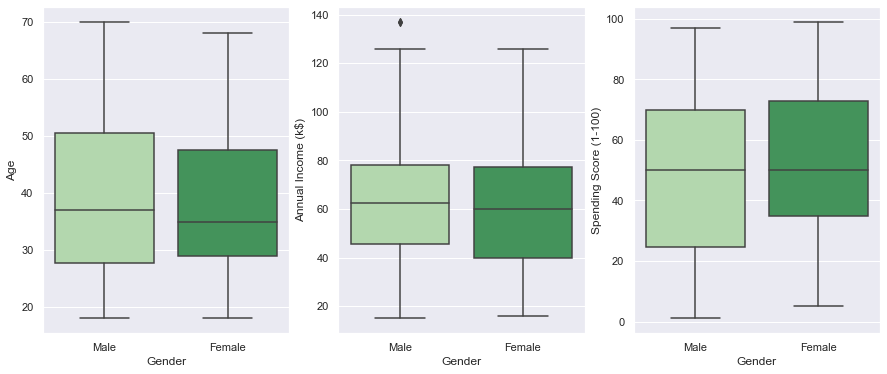

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for ax, col in zip(axes, df_eda.drop('Gender', axis=1).columns):
    sns.boxplot(data=df_eda, y=col, x='Gender', ax = ax, palette="Greens")
fig.show()

From comparing the distributions when grouped by age, it appears there is no significant difference between the distributions of males and females

To further test our hypothesis, we will perform a statistical two sample t-test on the means of both genders. 

In [17]:
df.pivot(columns='Gender')['Age']

Gender      Female  Male
CustomerID              
1              NaN  19.0
2              NaN  21.0
3             20.0   NaN
4             23.0   NaN
5             31.0   NaN
...            ...   ...
196           35.0   NaN
197           45.0   NaN
198            NaN  32.0
199            NaN  32.0
200            NaN  30.0

[200 rows x 2 columns]

In [18]:
def two_sample_t_test(data, col, level = 'Gender', equal_variances = True, significance_level = 0.05):
    pivoted_data = data.pivot(columns=level)[col]
    a, b = pivoted_data.iloc[:, 0].dropna(), pivoted_data.iloc[:, 1].dropna()
    text = f"Two Sample T-Test (assume {'' if equal_variances else 'no'} equal variances)\nH0 : Population means are equal\nH1 : Population means are not equal\nSignificance Level = {significance_level}"
    print(text)
    t_score, pvalue = stats.ttest_ind(a, b, equal_var=equal_variances)
    print("The p-value is", pvalue)
    if pvalue > significance_level:
        print("There is insufficient evidence to reject the null hypothesis that the population means are equal.")
    else:
        print("There is evidence to reject the null hypothesis that the population means are equal.")

In [19]:
df.groupby('Gender').var()

Age  Annual Income (k$)  Spending Score (1-100)
Gender                                                        
Female  159.873150          676.621622              581.530808
Male    240.709378          709.602926              778.229754

We observe that the sample variances of both samples are similar, hence we will assume equal variances.

In [20]:
for col in ('Age', 'Annual Income (k$)', 'Spending Score (1-100)'):
    print(col)
    two_sample_t_test(df, col)
    print()

Age
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.391890737788257
There is insufficient evidence to reject the null hypothesis that the population means are equal.

Annual Income (k$)
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.42755249399927864
There is insufficient evidence to reject the null hypothesis that the population means are equal.

Spending Score (1-100)
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.4137446589852176
There is insufficient evidence to reject the null hypothesis that the population means are equal.



From the t-test, it appears that Gender does not have a significant impact on the distribution of data.

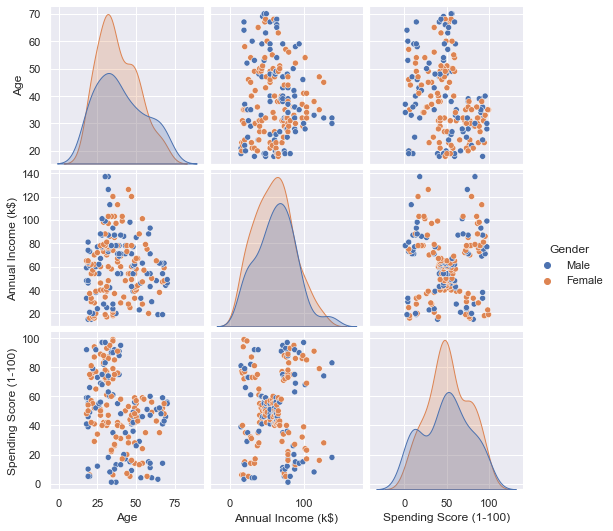

In [21]:
sns.pairplot(df_eda, hue="Gender")

We analysing the scatter plots when colored by gender, we see that the samples are not distinguishable.

## Data Preprocessing

Now, we will prepare our data for the clustering task.

To process our data, we will simply choose to drop the Gender variable. No scaling will be done on our data as our data are on a similar scale.

In [22]:
data = df.drop('Gender', axis=1)

## Clustering

### Utility Functions

In [23]:
def get_cluster_centroids(data):
    cluster_centers = data.groupby('Cluster').mean()
    cluster_centers['Cluster Size (% of Total)'] = pd.Series(data['Cluster']).value_counts() / len(data['Cluster']) * 100
    return cluster_centers

In [24]:
def elbow_plot(algo, data = data, n_clusters_max = 12, n_clusters_min = 2, figsize=(10, 8), model_params={}):
    n = list(range(n_clusters_min, n_clusters_max + 1))
    fig, ax = plt.subplots(figsize=figsize)
    inertia = []
    for no_cluster in n:
        model = algo(n_clusters=no_cluster, *model_params, random_state=rng)
        clusters = model.fit_predict(data)
        inertia.append(model.inertia_)
    ax.plot(n, inertia, 'o-')  
    ax.set_title("Elbow Plot")
    ax.set_ylabel('Inertia')
    ax.set_xlabel('No of Clusters')
    return fig

In [25]:
# Credit, code modified from: https://chart-studio.plotly.com/~Diksha_Gabha/2853.embed#:~:text=The%20silhouette%20plot%20displays%20a,of%20%5B%2D1%2C%201%5D.
def plot_silhouette(cluster_labels, data):
    n_clusters = len(np.unique(cluster_labels))
    cluster_centroids = data.groupby(cluster_labels).mean()
    avg_silhouette = silhouette_score(data, cluster_labels) # avg_silhouette gives us a measure of overall clustering quality
    print(f"Average Silhouette Score for {n_clusters} clusters: {avg_silhouette}")
    sample_silhouette_values = silhouette_samples(data, cluster_labels) # calculate silhouette scores for individual samples
    fig = make_subplots(rows=1, cols=2, print_grid=False, subplot_titles=('Silhouette Scores (by Clusters) Plot', 'Scatterplot of Clustering'), specs=[[{'type':'xy'}, {'type':'scene'}]])
    fig['layout']['xaxis1'].update(title='Silhouette Coefficient')
    fig['layout']['yaxis1'].update(title='Cluster Label', showticklabels=False, range=[0, len(data) + (n_clusters + 1) * 10])
    fig.update_scenes(dict(
        xaxis_title = 'Age',
        yaxis_title = 'Annual Income (k$)',
        zaxis_title = 'Spending Score (1-100)'
    ))
    y_lower = 10
    for i in range(n_clusters):
        cluster_silhouettes = sample_silhouette_values[cluster_labels == i]
        cluster_silhouettes.sort()
        cluster_size = cluster_silhouettes.shape[0]
        y_upper = y_lower + cluster_size
        #colors = cm.get_cmap("Spectral")
        colors = sns.color_palette('tab10')
        c = f'rgb({colors[i][0] * 255}, {colors[i][1] * 255}, {colors[i][2] * 255})'
        filled_area = go.Scatter(y=np.arange(y_lower, y_upper), x=cluster_silhouettes, mode='lines', showlegend=False, line=dict(width=0.5, color=c), fill='tozerox')
        y_lower = y_upper + 10
        fig.append_trace(filled_area, 1, 1)
    avg_line = go.Scatter(x=[avg_silhouette] * 500, y=np.arange(500), showlegend=False, mode='lines', line=dict(color='red', dash='dash', width=1), fill='tozeroy')
    fig.append_trace(avg_line, 1, 1)
    cmap = dict(zip(np.sort(np.unique(cluster_labels)), colors))
    scatter = go.Scatter3d(x = data['Age'], y=data['Annual Income (k$)'], z=data['Spending Score (1-100)'], mode='markers', marker=dict(color=list(map(lambda x : tuple(np.array(cmap[x]) * 255), cluster_labels))))
    fig.append_trace(go.Scatter3d(x=cluster_centroids['Age'], y=cluster_centroids['Annual Income (k$)'], z=cluster_centroids['Spending Score (1-100)'], mode='markers', marker=dict(symbol='diamond', color='black')), 1, 2)
    fig.append_trace(scatter, 1, 2)
        
    return fig, avg_silhouette

In [26]:
def test_clusters(model, data, n_range = range(2, 10), model_params = {}):
    try:
        figures, models = tuple(zip(*[plot_silhouette(labels, data) for labels, n_clusters in [
            (model(n_clusters=i, **model_params).fit_predict(data), i) for i in n_range
        ]]))
    except:
        figures, models = tuple(zip(*[plot_silhouette(labels, data) for labels, n_clusters in [
            (model(n_components=i, **model_params).fit_predict(data), i) for i in n_range
        ]]))
    return figures, models

In [27]:
def plot_dendrogram(h_clust):
    counts = np.zeros(h_clust.children_.shape[0])
    n_samples = len(h_clust.labels_)
    for i, merge in enumerate(h_clust.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage = np.column_stack([h_clust.children_, h_clust.distances_, counts]).astype(float)
    fig, ax = plt.subplots(figsize=(12, 12))
    dendrogram(linkage, ax=ax, truncate_mode='level', p=3)
    return fig

### K-Means Clustering

#### Clustering Result

In [28]:
kmeans_df = data.copy()
model = KMeans(random_state=rng)
cluster_labels = model.fit_predict(data) + 1
kmeans_df['Cluster'] = cluster_labels

In [29]:
cluster_centers = get_cluster_centroids(kmeans_df)
cluster_centers

Age  Annual Income (k$)  Spending Score (1-100)  \
Cluster                                                          
1        41.960000           79.640000               15.400000   
2        56.340909           53.704545               49.386364   
3        32.862069           78.551724               82.172414   
4        25.272727           25.727273               79.363636   
5        44.318182           25.772727               20.272727   
6        27.000000           56.657895               49.131579   
7        41.000000          109.700000               22.000000   
8        32.200000          109.700000               82.000000   

         Cluster Size (% of Total)  
Cluster                             
1                             12.5  
2                             22.0  
3                             14.5  
4                             11.0  
5                             11.0  
6                             19.0  
7                              5.0  
8                              5.0

In [30]:
fig, score = plot_silhouette(kmeans_df['Cluster'], kmeans_df)
fig

Average Silhouette Score for 8 clusters: 0.4354834763679996


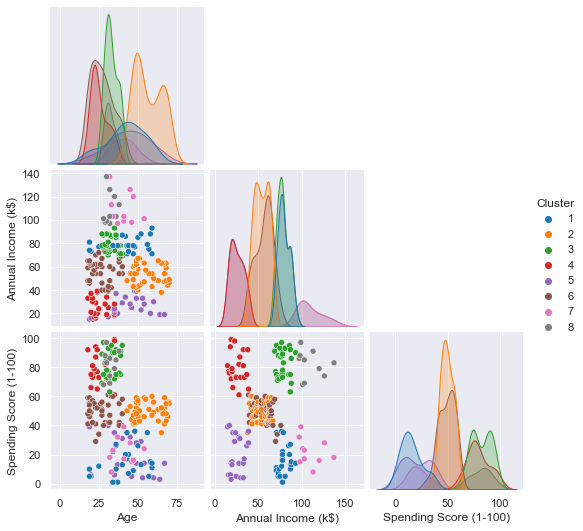

In [31]:
sns.pairplot(kmeans_df, hue='Cluster', corner=True, palette="tab10")

In [32]:
cluster_centers

Age  Annual Income (k$)  Spending Score (1-100)  \
Cluster                                                          
1        41.960000           79.640000               15.400000   
2        56.340909           53.704545               49.386364   
3        32.862069           78.551724               82.172414   
4        25.272727           25.727273               79.363636   
5        44.318182           25.772727               20.272727   
6        27.000000           56.657895               49.131579   
7        41.000000          109.700000               22.000000   
8        32.200000          109.700000               82.000000   

         Cluster Size (% of Total)  
Cluster                             
1                             12.5  
2                             22.0  
3                             14.5  
4                             11.0  
5                             11.0  
6                             19.0  
7                              5.0  
8                              5.0

### Hierarchical Clustering

#### Clustering Result

#### Default Parameters

In [33]:
h_clust_df = data.copy()
h_clust = AgglomerativeClustering()
cluster_labels = h_clust.fit_predict(data) + 1
h_clust_df['Cluster'] = cluster_labels

In [34]:
fig, score = plot_silhouette(h_clust_df['Cluster'], h_clust_df)
fig

Average Silhouette Score for 2 clusters: 0.2993791526098483


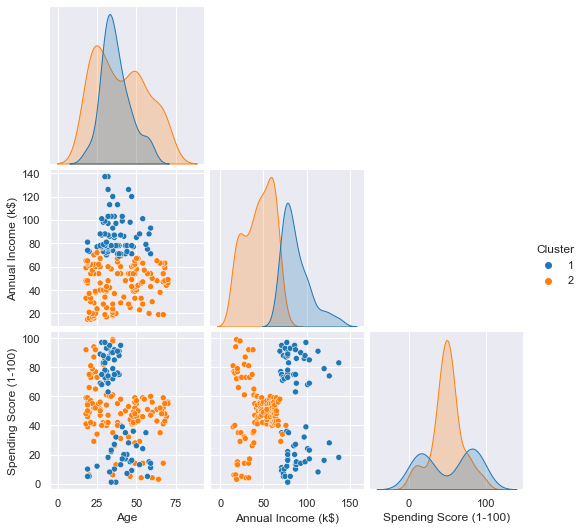

In [35]:
sns.pairplot(h_clust_df, hue='Cluster', corner=True, palette="tab10")

In [36]:
cluster_centers = get_cluster_centroids(h_clust_df)
cluster_centers

Age  Annual Income (k$)  Spending Score (1-100)  \
Cluster                                                          
1        36.945946           87.337838               51.459459   
2        39.968254           44.833333               49.460317   

         Cluster Size (% of Total)  
Cluster                             
1                             37.0  
2                             63.0

### Gaussian Mixture Model

#### Clustering Result

In [37]:
gmm_df = data.copy()

cluster_labels = GaussianMixture(5, random_state=rng).fit_predict(gmm_df) +1

gmm_df['Cluster'] = cluster_labels
cluster_centers = get_cluster_centroids(gmm_df)

In [38]:
fig, score = plot_silhouette(gmm_df['Cluster'], gmm_df)
fig

Average Silhouette Score for 5 clusters: 0.41691129027911006


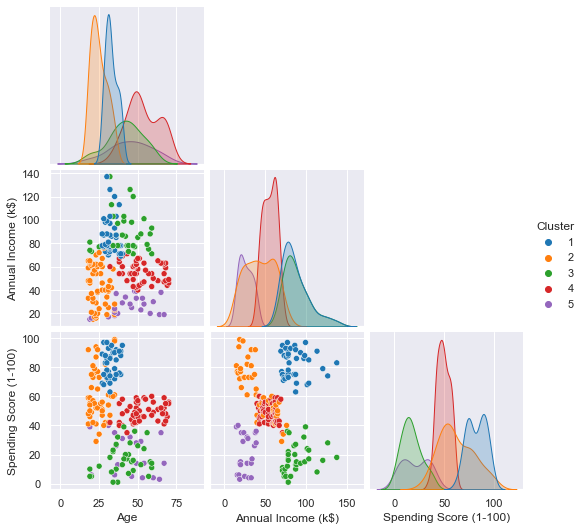

In [39]:
sns.pairplot(gmm_df, hue='Cluster', corner=True, palette="tab10")

In [40]:
cluster_centers

Age  Annual Income (k$)  Spending Score (1-100)  \
Cluster                                                          
1        32.692308           86.538462               82.128205   
2        24.830189           43.226415               62.037736   
3        41.647059           88.735294               16.764706   
4        53.392157           55.372549               48.980392   
5        45.217391           26.304348               20.913043   

         Cluster Size (% of Total)  
Cluster                             
1                             19.5  
2                             26.5  
3                             17.0  
4                             25.5  
5                             11.5

## Model Improvement

### Selecting the Optimal Number of Clusters

In our initial modelling, we stuck (with the exception of GMM), to the default number of clusters. However, as we have seen, the default number of clusters does not appear to produce good clustering results. Hence, it is necessary to improve our clustering by finding the best number of clusters. From our EDA, a good guess for the number of clusters would be 5 clusters, but we need to look further into this.

#### K-Means
##### Elbow Plot

We start by using an elbow plot, which plots the Inertia of the K-Means clusters, as the number of clusters increase. The lower the inertia (within-cluster sum-of-squares), the more tightly packed each cluster is. We expect the inertia to decrease with more clusters. To identify a good number of clusters, we want to find the point (an elbow), where the decrease in inertia slows down, suggesting we are getting diminishing returns.

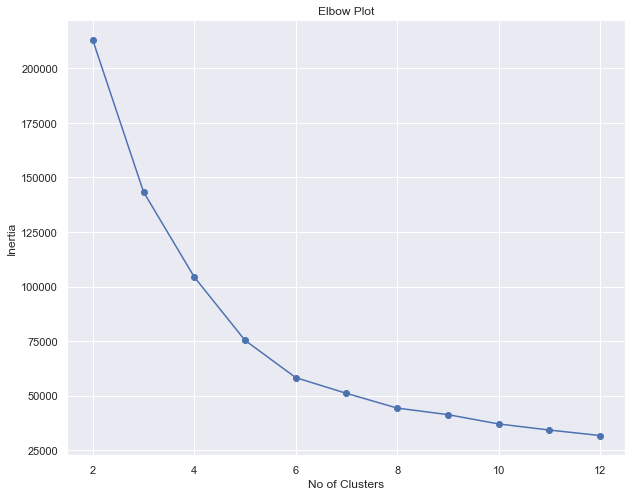

In [41]:
fig = elbow_plot(KMeans)

From looking at the elbow plot, we note that the optimal number of clusters appears to be between 6 to 8, as the elbow is not very obvious. As a result, we will want to further narrow down the number of clusters through other methods.

##### Silhouette Analysis
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of $[-1, 1]$.

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

What we can do is to analyse the silhouette scores of the clusters, and see which clusters have very low silhouette scores, indicating they are poorly defined. The average silhouette score will be a measure of the overall quality of clusters formed.

In [42]:
figures, kmeans_models = test_clusters(KMeans, data, n_range=range(5, 9))

Average Silhouette Score for 5 clusters: 0.44428597560893024
Average Silhouette Score for 6 clusters: 0.4523566166018854
Average Silhouette Score for 7 clusters: 0.43978902692261157
Average Silhouette Score for 8 clusters: 0.42786362446871096


Just based on average silhouette alone, we can see that 6 clusters is the optimal number of clusters, but we will also analyse 5 clusters

###### 5 Clusters

In [43]:
figures[0]

###### 6 Clusters

In [44]:
figures[1]

#### Hierarchical Clustering

The default parameters of hierarchical clustering only distinguish between more and less affluent customers, which is not detailed enough for us to make any recommendations. Hence, we will also need to search for better clusters. We suspect that our result will be similar to K-Means.

##### Using a Dendrogram to Select the Number of Clusters

Hierarchical clustering allows us to construct a dendrogram, which plots the distances/dissimilarity between clusters in the vertical axis. We can use the dendrogram to select the number of clusters by cutting off the dendrogram when the clusters formed start becoming too similar.

In [45]:
h_clust = AgglomerativeClustering(compute_distances=True)
h_clust.fit(data)

AgglomerativeClustering(compute_distances=True)

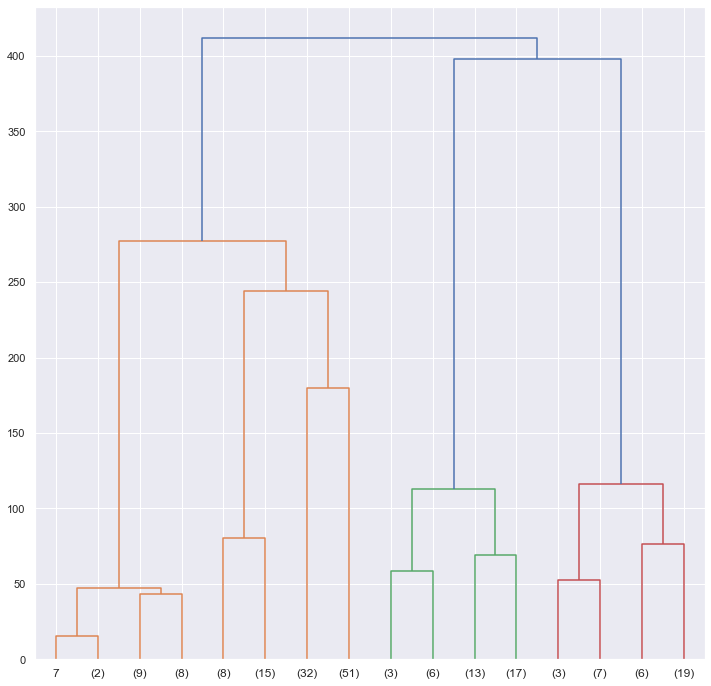

In [46]:
fig = plot_dendrogram(h_clust)

In the Dendrogram, we can cut off the dendrogram at around 130 units, creating 6 clusters. After that, the clusters becoming increasingly less well defined.

In [47]:
h_clust_df = data.copy()
h_clust = AgglomerativeClustering(6)
cluster_labels = h_clust.fit_predict(data) + 1
h_clust_df['Cluster'] = cluster_labels

fig, score = plot_silhouette(h_clust_df['Cluster'], h_clust_df)
fig

Average Silhouette Score for 6 clusters: 0.4458768117218558


#### Gaussian Mixture Model

##### BIC Plot
Similar to a k-means elbow plot, we can use an BIC plot to plot the Bayesian Information Criterion of the GMM. We will then observe where the BIC of the model is lowest to gauge the optimal number of clusters

In [48]:
bic = []

for n_components in range(1, 9):
    model = GaussianMixture(n_components=n_components, random_state=rng)
    model.fit(data)
    bic.append(model.bic(data))

best_n_components = np.argmin(bic) + 1
print("Best number of components:", best_n_components)

Best number of components: 5


Text(0, 0.5, 'BIC')

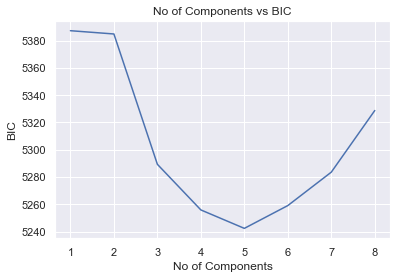

In [49]:
pd.Series(bic, index=range(1, 9)).plot()
plt.title("No of Components vs BIC")
plt.xlabel("No of Components")
plt.ylabel("BIC")

From the BIC, we see that 4 or 6 clusters is the optimal number of clusters. We will want to analyse this further, and so use silhouette analysis.

##### Silhouette Analysis

In [50]:
figures, gmm_models = test_clusters(GaussianMixture, data, n_range=range(4, 7))

Average Silhouette Score for 4 clusters: 0.3776529904023892
Average Silhouette Score for 5 clusters: 0.4162356745989718
Average Silhouette Score for 6 clusters: 0.4458378313266269


From the silhouette score, we see that 6 clusters produces the most well defined clusters.

###### 4 Clusters

In [51]:
figures[0]

###### 6 Clusters

In [52]:
figures[2]

#### Increasing the Number of Initialization for K Means

In [53]:
kmeans_df = data.copy()
model = KMeans(6, random_state=rng, n_init=500)
cluster_labels = model.fit_predict(data) + 1
kmeans_df['Cluster'] = cluster_labels
fig, score = plot_silhouette(kmeans_df['Cluster'], kmeans_df)
fig

Average Silhouette Score for 6 clusters: 0.45522746149025317


## Final Model

In [55]:
final_df = data.copy()
model = KMeans(6, random_state=rng, n_init=500)
cluster_labels = model.fit_predict(final_df) + 1
final_df['Cluster'] = cluster_labels
fig, score = plot_silhouette(final_df['Cluster'], final_df)
fig

Average Silhouette Score for 6 clusters: 0.45384005594165344


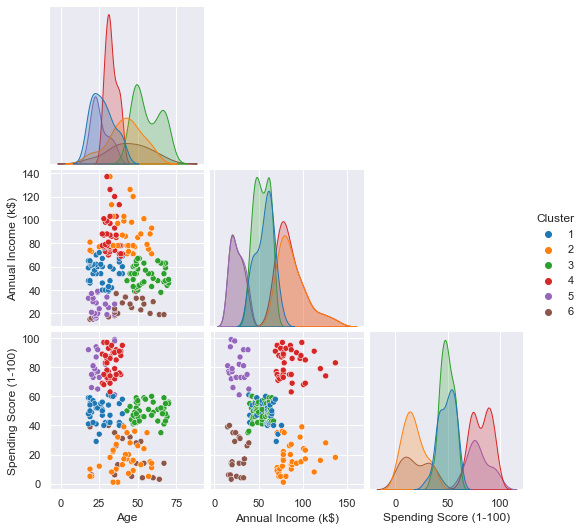

In [56]:
sns.pairplot(final_df, hue='Cluster', corner=True, palette="tab10")

In [57]:
cluster_centers = get_cluster_centroids(final_df)
cluster_centers

Age  Annual Income (k$)  Spending Score (1-100)  \
Cluster                                                          
1        27.000000           56.657895               49.131579   
2        41.685714           88.228571               17.285714   
3        56.155556           53.377778               49.088889   
4        32.692308           86.538462               82.128205   
5        25.272727           25.727273               79.363636   
6        44.142857           25.142857               19.523810   

         Cluster Size (% of Total)  
Cluster                             
1                             19.0  
2                             17.5  
3                             22.5  
4                             19.5  
5                             11.0  
6                             10.5

### Interpretation

## Recommendations

In [54]:
kmeans_df = data.copy()
model = KMeans(6, random_state=rng)
cluster_labels = model.fit_predict(data) + 1
kmeans_df['Cluster'] = cluster_labels